In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/02 - Time Series/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/02 - Time Series


In [ ]:
pip install pmdarima

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ExpS
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from pandas.plotting import lag_plot
from pmdarima import auto_arima
from statsmodels.tsa.api import VAR

# Forecasting with the Holt-Winters Method

In [4]:
df = pd.read_csv('./data/airline_passengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'
df.sample(5)

,Thousands of Passengers
Month,
1959-04-01,396
1952-04-01,181
1960-05-01,472
1956-06-01,374
1957-11-01,305


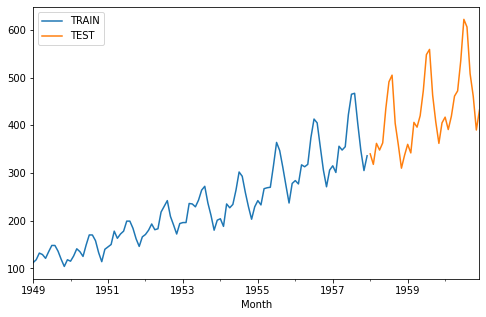

In [5]:
# splitting
train_data = df.iloc[:108]
test_data = df.iloc[108:]

# plotting
train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(8,5));

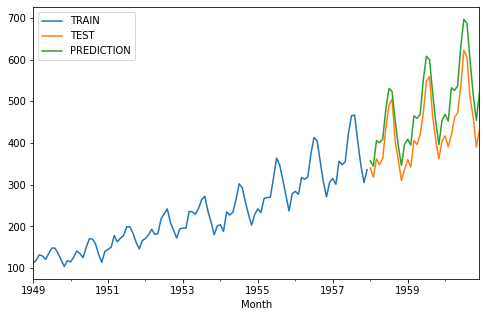

In [6]:
fitted_model = ExpS(train_data['Thousands of Passengers'], trend='mul', seasonal='mul', seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(36).rename('HW Forecast')

train_data['Thousands of Passengers'].plot(legend=True, label='TRAIN')
test_data['Thousands of Passengers'].plot(legend=True, label='TEST', figsize=(8, 5))
test_predictions.plot(legend=True, label='PREDICTION');

In [7]:
# rmse
np.sqrt(mean_squared_error(test_data,test_predictions))

59.3792600883759

# ACF and PACF
Before we can investigate <em>autoregression</em> as a modeling tool, we need to look at <em>covariance</em> and <em>correlation</em> as they relate to lagged (shifted) samples of a time series.
 
<br />
<strong>
<a href='https://en.wikipedia.org/wiki/Autocovariance'>Wikipedia:</a></strong>&nbsp;&nbsp;<font>Autocovariance</font><br>
<strong>
<a href='https://otexts.com/fpp2/autocorrelation.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font>Autocorrelation</font><br>
<strong>
<a href='https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm'>NIST Statistics Handbook</a></strong>&nbsp;&nbsp;<font>Partial Autocorrelation Plot</font></div>


## Autocovariance for 1D
In a <em>deterministic</em> process, like $y=sin(x)$, we always know the value of $y$ for a given value of $x$. However, in a <em>stochastic</em> process there is always some randomness that prevents us from knowing the value of $y$. Instead, we analyze the past (or <em>lagged</em>) behavior of the system to derive a probabilistic estimate for $\hat{y}$.

One useful descriptor is <em>covariance</em>. When talking about dependent and independent $x$ and $y$ variables, covariance describes how the variance in $x$ relates to the variance in $y$. Here the size of the covariance isn't really important, as $x$ and $y$ may have very different scales. However, if the covariance is positive it means that $x$ and $y$ are changing in the same direction, and may be related.

With a time series, $x$ is a fixed interval. Here we want to look at the variance of $y_t$ against lagged or shifted values of $y_{t+k}$

For a stationary time series, the autocovariance function for $\gamma$ (gamma) is given as:

${\displaystyle {\gamma}_{XX}(t_{1},t_{2})=\operatorname {Cov} \left[X_{t_{1}},X_{t_{2}}\right]=\operatorname {E} [(X_{t_{1}}-\mu _{t_{1}})(X_{t_{2}}-\mu _{t_{2}})]}$

We can calculate a specific $\gamma_k$ with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})}$


### Autocovariance Example:
Say we have a time series with five observations: {13, 5, 11, 12, 9}.<br>
We can quickly see that $n = 5$, the mean $\bar{y} = 10$, and we'll see that the variance $\sigma^2 = 8$.<br>
The following calculations give us our covariance values:
<br><br>
$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} 5 = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} 5 = \frac {-20} 5 = -4.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} 5 = \frac {-8} 5 = -1.6 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} 5 = \frac {11} 5 = 2.2 \\
\gamma_4 = \frac {(13-10)(9-10)} 5 = \frac {-3} 5 = -0.6$
<br><br>
Note that $\gamma_0$ is just the population variance $\sigma^2$

In [8]:
df = pd.DataFrame({'a':[13, 5, 11, 12, 9]})
acovf(df['a'])

array([ 8. , -4. , -1.6,  2.2, -0.6])

### Unbiased Autocovariance
Note that the number of terms in the calculations above are decreasing.<br>Statsmodels can return an "unbiased" autocovariance where instead of dividing by $n$ we divide by $n-k$.

$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} {5-0} = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} {5-1} = \frac {-20} 4 = -5.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} {5-2} = \frac {-8} 3 = -2.67 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} {5-3} = \frac {11} 2 = 5.5 \\
\gamma_4 = \frac {(13-10)(9-10)} {5-4} = \frac {-3} 1 = -3.0$

In [9]:
acovf(df['a'],unbiased=True)

array([ 8.        , -5.        , -2.66666667,  5.5       , -3.        ])

## Autocorrelation for 1D
The correlation $\rho$ (rho) between two variables $y_1,y_2$ is given as:

$\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

where $E$ is the expectation operator, $\mu_{1},\sigma_{1}$ and $\mu_{2},\sigma_{2}$ are the means and standard deviations of $y_1$ and $y_2$.

When working with a single variable (i.e. <em>autocorrelation</em>) we would consider $y_1$ to be the original series and $y_2$ a lagged version of it. Note that with autocorrelation we work with $\bar y$, that is, the full population mean, and <em>not</em> the means of the reduced set of lagged factors (see note below).

Thus, the formula for $\rho_k$ for a time series at lag $k$ is:

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

This can be written in terms of the covariance constant $\gamma_k$ as:

${\displaystyle \rho_k = \frac {\gamma_k n} {\gamma_0 n} = \frac {\gamma_k} {\sigma^2}}$

For example,<br>
$\rho_4 = \frac {\gamma_4} {\sigma^2} = \frac{-0.6} {8} = -0.075$

Note that ACF values are bound by -1 and 1. That is, ${\displaystyle -1 \leq \rho_k \leq 1}$

In [10]:
df['a']

0    13
1     5
2    11
3    12
4     9
Name: a, dtype: int64

## Partial Autocorrelation
Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag $k$ is the autocorrelation between $y_t$ and $y_{t+k}$ that is not accounted for by lags $1$ through $k−1$.

A common method employs the non-recursive <a href='https://en.wikipedia.org/wiki/Autoregressive_model#Calculation_of_the_AR_parameters'>Yule-Walker Equations</a>:

$\phi_0 = 1\\
\phi_1 = \rho_1 = -0.50\\
\phi_2 = \frac {\rho_2 - {\rho_1}^2} {1-{\rho_1}^2} = \frac {(-0.20) - {(-0.50)}^2} {1-{(-0.50)}^2}= \frac {-0.45} {0.75} = -0.60$

As $k$ increases, we can solve for $\phi_k$ using matrix algebra and the <a href='https://en.wikipedia.org/wiki/Levinson_recursion'>Levinson–Durbin recursion</a> algorithm which maps the sample autocorrelations $\rho$ to a <a href='https://en.wikipedia.org/wiki/Toeplitz_matrix'>Toeplitz</a> diagonal-constant matrix. The full solution is beyond the scope of this course, but the setup is as follows:


$\displaystyle \begin{pmatrix}\rho_0&\rho_1&\cdots &\rho_{k-1}\\
\rho_1&\rho_0&\cdots &\rho_{k-2}\\
\vdots &\vdots &\ddots &\vdots \\
\rho_{k-1}&\rho_{k-2}&\cdots &\rho_0\\
\end{pmatrix}\quad \begin{pmatrix}\phi_{k1}\\\phi_{k2}\\\vdots\\\phi_{kk}\end{pmatrix}
\mathbf = \begin{pmatrix}\rho_1\\\rho_2\\\vdots\\\rho_k\end{pmatrix}$

In [11]:
pacf_yw(df['a'],nlags=4,method='mle')

array([ 1.        , -0.5       , -0.6       , -0.38541667, -0.40563273])

<div class="alert alert-info"><strong>NOTE:</strong> We passed in <tt><font color=black>method='mle'</font></tt> above in order to use biased ACF coefficients. "mle" stands for "maximum likelihood estimation". Alternatively we can pass <tt>method='unbiased'</tt> (the statsmodels default):</div>

In [12]:
pacf_yw(df['a'],nlags=4,method='unbiased')

array([ 1.        , -0.625     , -1.18803419,  2.03764205,  0.8949589 ])

In [13]:
# Partial Autocorrelation with OLS
pacf_ols(df['a'],nlags=4)

array([ 1.        , -0.49677419, -0.43181818,  0.53082621,  0.25434783])

## Plotting

In [14]:
# Load a non-stationary dataset
df1 = pd.read_csv('./data/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a stationary dataset
df2 = pd.read_csv('./data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

### ACF Plot

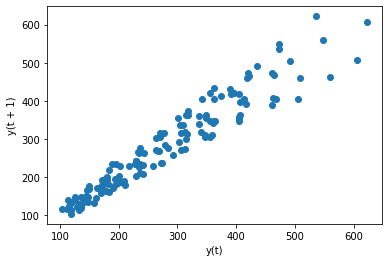

In [15]:
lag_plot(df1['Thousands of Passengers']);

Visually this shows evidence of a very strong autocorrelation; as $y_t$ values increase, nearby (lagged) values also increase.

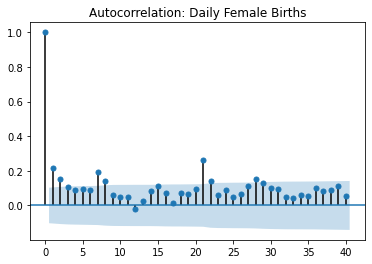

In [16]:
# Autocorrelation at different lags
title = 'Autocorrelation: Daily Female Births'
lags = 40
plot_acf(df2,title=title,lags=lags);

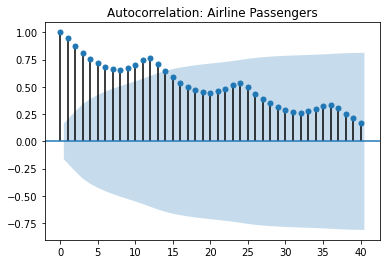

In [17]:
title = 'Autocorrelation: Airline Passengers'
lags = 40
plot_acf(df1,title=title,lags=lags);

### PACF Plots
Partial autocorrelations work best with stationary data. Let's look first at <strong>Daily Total Female Births</strong>:

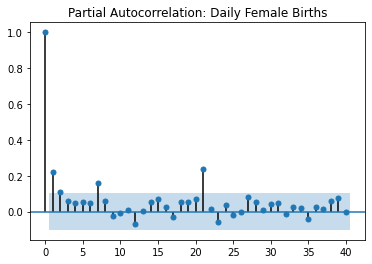

In [18]:
title='Partial Autocorrelation: Daily Female Births'
lags=40
plot_pacf(df2,title=title,lags=lags);

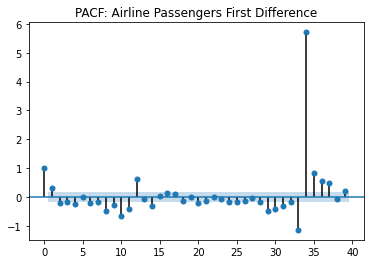

In [19]:
# To make the Airline Passengers data stationary, we'll first apply differencing:
df1['d1'] = diff(df1['Thousands of Passengers'],k_diff=1)
title='PACF: Airline Passengers First Difference'
lags=40
plot_pacf(df1['d1'].dropna(),title=title,lags=np.arange(lags));  # be sure to add .dropna() here!

<div class="alert alert-success"><strong>A NOTE ABOUT AUTOCORRELATION:</strong> Some texts compute lagged correlations using the Pearson Correlation Coefficient given by:<br><br>
${\displaystyle r_{xy}={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}}}$

These are easily calculated in numpy with <tt>numpy.corrcoef(x,y)</tt> and in Excel with <tt>=CORREL(x,y)</tt>.<br><br>
Using our example, $r_0$ is still $1$, but to solve for $r_1$:

${\displaystyle x_1 = [13, 5, 11, 12], \bar{x_1} = 10.25}$<br><br>
$y_1 = [5, 11, 12, 9],\  \bar{y_1} = 9.25$<br><br>
$r_{{x_1}{y_1}}=\frac {(13-10.25)(5-9.25)+(5-10.25)(11-9.25)+(11-10.25)(12-9.25)+(12-10.25)(9-9.25)}
{\sqrt{((13-10.25)^2+(5-10.25)^2+(11-10.25)^2+(12-10.25)^2)}\sqrt{((5-9.25)^2+(11-9.25)^2+(12-9.25)^2+(9-9.25)^2)}} = \frac {-19.25} {33.38} = -0.577$
<br><br>
However, there are some shortcomings. Using the Pearson method, the second-to-last term $r_{k-1}$ will always be $1$ and the last term $r_k$ will always be undefined.
</div>

# ARIMA

<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In [20]:
# Load a non-stationary dataset
df1 = pd.read_csv('./data/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a stationary dataset
df2 = pd.read_csv('./data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

## pmdarima

To find the best parameters for Arima

In [21]:
stepwise_fit = auto_arima(df2['Births'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True, 
                          stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2650.760, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2565.234, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2463.584, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2648.768, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2460.154, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2461.271, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2460.722, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2536.154, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2463.066, Time=0.73 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2459.074, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2462.221, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2563.261, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2460.367, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1226.537
Date:                Sat, 24 Apr 2021   AIC                           2459.074
Time:                        04:33:08   BIC                           2470.766
Sample:                             0   HQIC                          2463.721
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1252      0.060      2.097      0.036       0.008       0.242
ma.L1         -0.9624      0.017    -56.429      0.000      -0.996      -0.929
sigma2        49.1512      3.250     15.122      0.000      42.781      55.522
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                25.33
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.57
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA

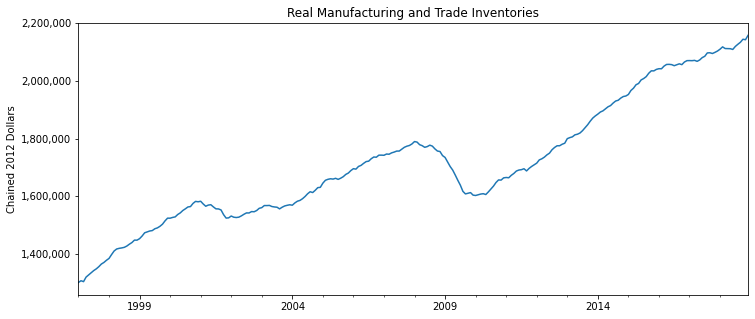

In [22]:
df2 = pd.read_csv('./data/TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'

import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

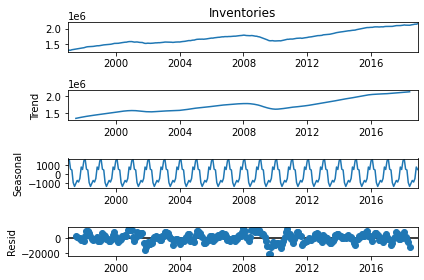

In [23]:
result = seasonal_decompose(df2['Inventories'], model='additive')  # model='add' also works
result.plot();

In [24]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [25]:
adf_test(df2['Inventories'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.087684
p-value                   0.950652
# lags used               5.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>
Alternatively, we can compare the stepwise <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike Information Criterion (AIC)</a> values across a set of different (p,q) combinations to choose the best combination.

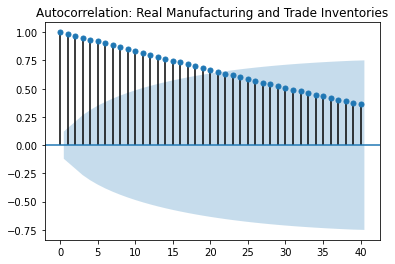

In [26]:
title = 'Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_acf(df2['Inventories'],title=title,lags=lags);

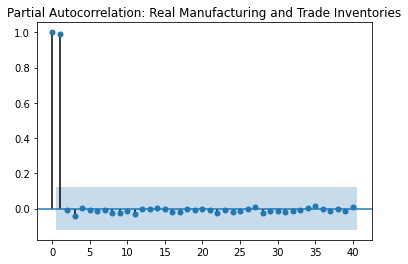

In [27]:
title = 'Partial Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_pacf(df2['Inventories'],title=title,lags=lags);

This tells us that the AR component should be more important than MA. From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:<br>
> <em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

Let's take a look at <tt>pmdarima.auto_arima</tt> done stepwise to see if having $p$ and $q$ terms the same still makes sense:

In [28]:
stepwise_fit = auto_arima(df2['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5348.037, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5399.843, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5350.241, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5409.217, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5378.835, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.280 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Sat, 24 Apr 2021   AIC                           5348.037
Time:                        04:33:10   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# Set one year for testing
train = df2.iloc[:252]
test = df2.iloc[252:]

model = ARIMA(train['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.395
Method:                       css-mle   S.D. of innovations           4845.028
Date:                Sat, 24 Apr 2021   AIC                           4980.790
Time:                        04:33:10   BIC                           4994.892
Sample:                    02-01-1997   HQIC                          4986.465
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3197.5697   1344.875      2.378      0.017     561.663    5833.477
ar.L1.D.Inventories     0.9026      0.039     23.011      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7918           +0.0000j            1.7918            0.0000
-----------------------------------------------------------------------------
"""

In [30]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

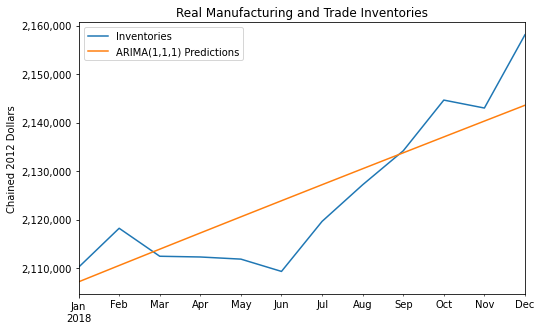

In [31]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = test['Inventories'].plot(legend=True,figsize=(8,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [32]:
error = mean_squared_error(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) MSE Error: {error:11.10}')
error = rmse(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) RMSE Error: {error:11.10}')

ARIMA(1,1,1) MSE Error: 60677819.87
ARIMA(1,1,1) RMSE Error: 7789.596901


# SARIMA

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font></di

In [33]:
df = pd.read_csv('./data/co2_mm_mlo.csv')
df['date'] = pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))
df.set_index('date',inplace=True)
df.index.freq = 'MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


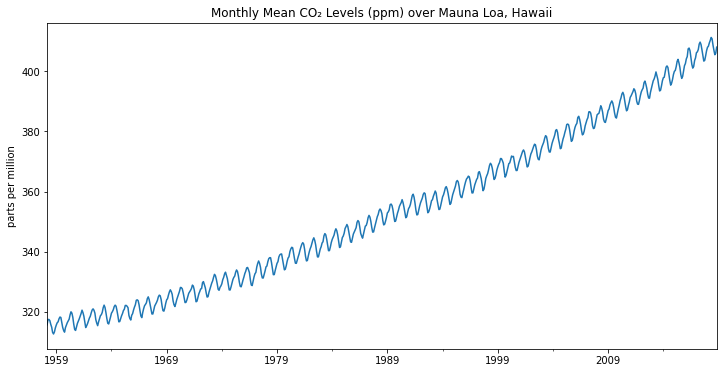

In [34]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [35]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['interpolated'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -205.693
Date:                              Sat, 24 Apr 2021   AIC                            423.387
Time:                                      04:37:10   BIC                            450.929
Sample:                                           0   HQIC                           434.014
                                              - 729                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3549      0.034    -10.294      0.000      -0.422      -0.287
ma.L2         -0.0230      0.032     -0.712      0.476      -0.086       0.040
ma.L3         -0.0836      0.032     -2.607      0.009      -0.146      -0.021
ar.S.L12       0.9996      0.000   2988.504      0.000       0.999       1.000
ma.S.L12      -0.8666      0.021    -40.715      0.000      -0.908      -0.825
sigma2         0.0956      0.005     20.342      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 4.03
Prob(Q):                              0.77   Prob(JB):                         0.13
Heteroskedasticity (H):               1.13   Skew:                             0.00
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
train = df.iloc[:717]
test = df.iloc[717:]

In [37]:
model = SARIMAX(train['interpolated'],order=(0,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -205.151
Date:                            Sat, 24 Apr 2021   AIC                            418.302
Time:                                    04:37:12   BIC                            436.597
Sample:                                03-01-1958   HQIC                           425.367
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3695      0.034    -10.745      0.000      -0.437      -0.302
ar.S.L12       0.9997      0.000   3123.769      0.000       0.999       1.000
ma.S.L12      -0.8645      0.023    -37.591      0.000      -0.910      -0.819
sigma2         0.0960      0.005     20.155      0.000       0.087       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 3.74
Prob(Q):                              0.73   Prob(JB):                         0.15
Heteroskedasticity (H):               1.13   Skew:                            -0.02
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, 
                              end=end, 
                              dynamic=False, 
                              typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

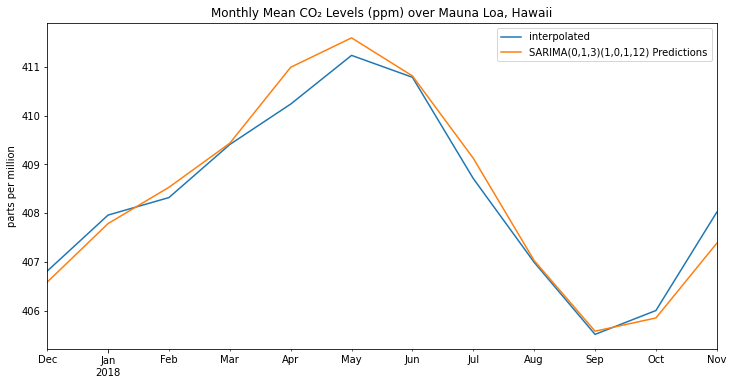

In [39]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# SARIMAX

Introduce the idea that external factors (environmental, economic, etc.) can also influence a time series, and be used in forecasting.


<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font><br>
<strong>
<a href='https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_stata.html'>Statsmodels Example:</a></strong>&nbsp;&nbsp;<font color=black>SARIMAX</font></div>

In [40]:
# Load dataset
df = pd.read_csv('./data/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'
df1 = df.dropna()
cols = ['rest1','rest2','rest3','rest4','total']
df1[cols] = df1[cols].astype(int)
df1.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-18,Tuesday,0,na,30,30,13,18,91
2017-04-19,Wednesday,0,na,20,11,30,18,79
2017-04-20,Thursday,0,na,22,3,19,46,90
2017-04-21,Friday,0,na,38,53,36,38,165
2017-04-22,Saturday,0,na,97,20,50,59,226


In [41]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

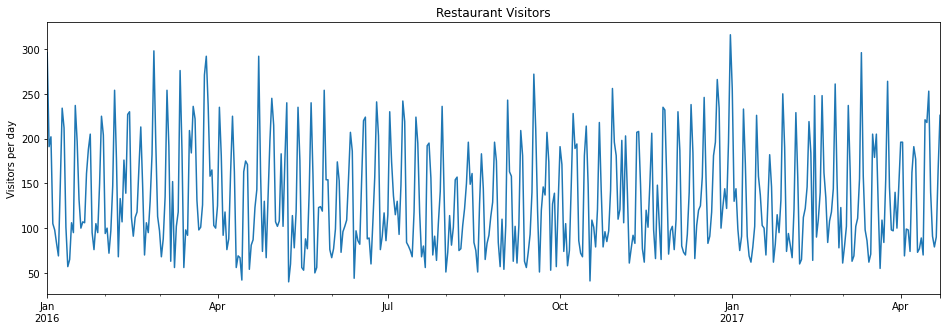

In [42]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [43]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2383.845
Date:                   Sat, 24 Apr 2021   AIC                           4775.690
Time:                           04:37:45   BIC                           4792.369
Sample:                                0   HQIC                          4782.247
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.7613      1.654      2.878      0.004       1.519       8.003
ar.S.L7        0.9624      0.013     75.584      0.000       0.937       0.987
ma.S.L7       -0.7581      0.048    -15.672      0.000      -0.853      -0.663
sigma2      1205.5235     70.693     17.053      0.000    1066.968    1344.079
===================================================================================
Ljung-Box (L1) (Q):                  16.20   Jarque-Bera (JB):                64.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.75
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMAX

In [44]:
model_sarimax = SARIMAX(train['total'], 
                        exog=train['holiday'],
                        order=(1,0,0),
                        seasonal_order=(2,0,0,7),
                        enforce_invertibility=False)
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2158.482
Date:                           Sat, 24 Apr 2021   AIC                           4326.963
Time:                                   04:37:47   BIC                           4347.352
Sample:                               01-01-2016   HQIC                          4335.010
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       66.8878      4.241     15.773      0.000      58.576      75.199
ar.L1          0.2145      0.049      4.375      0.000       0.118       0.311
ar.S.L7        0.5147      0.042     12.312      0.000       0.433       0.597
ar.S.L14       0.4575      0.042     10.997      0.000       0.376       0.539
sigma2      1117.3920     73.301     15.244      0.000     973.725    1261.059
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.68   Prob(JB):                         0.54
Heteroskedasticity (H):               0.91   Skew:                             0.11
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions_sarimax = results_sarimax.predict(start=start, 
                                              end=end, 
                                              exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Predictions')

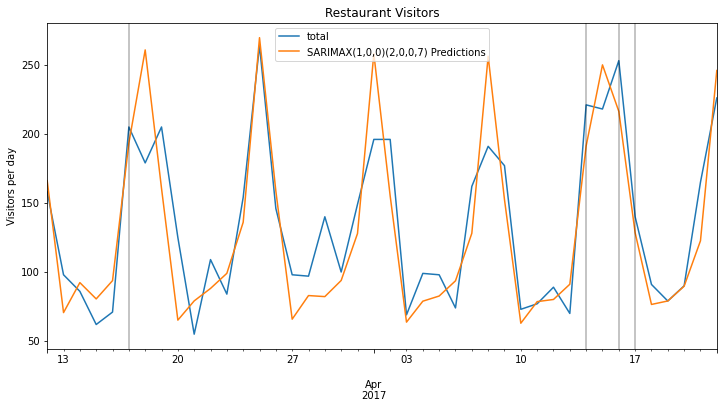

In [46]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha=0.3);

In [47]:
# predicted values for sarima
model_sarima = SARIMAX(train['total'], 
                       order=(1,0,0), 
                       seasonal_order=(2,0,0,7), 
                       enforce_invertibility=False)
results_sarima = model_sarima.fit()
predictions_sarima = results_sarima.predict(start=start, end=end, dynamic=False)

In [48]:
from statsmodels.tools.eval_measures import mse,rmse

# Print values from SARIMA above
error1 = mse(test['total'], predictions_sarima)
error2 = rmse(test['total'], predictions_sarima)

print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')
print()

# Print new SARIMAX values
error1x = mse(test['total'], predictions_sarimax)
error2x = rmse(test['total'], predictions_sarimax)

print(f'SARIMAX(1,0,0)(2,0,0,7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(2,0,0,7) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.647957
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26315495

SARIMAX(1,0,0)(2,0,0,7) MSE Error: 950.6735446
SARIMAX(1,0,0)(2,0,0,7) RMSE Error: 30.83299441


# VAR

## Vector-AutoRegression

there are some cases where variables affect each other. <a href='https://otexts.com/fpp2/VAR.html'>Forecasting: Principles and Practice</a> describes a case where changes in personal consumption expenditures $C_t$ were forecast based on changes in personal disposable income $I_t$.
> However, in this case a bi-directional relationship may be more suitable: an increase in $I_t$ will lead to an increase in $C_t$ and vice versa.<br>An example of such a situation occurred in Australia during the Global Financial Crisis of 2008–2009. The Australian government issued stimulus packages that included cash payments in December 2008, just in time for Christmas spending. As a result, retailers reported strong sales and the economy was stimulated. Consequently, incomes increased.

Aside from investigating multivariate time series, vector autoregression is used for
* <a href='https://www.statsmodels.org/devel/vector_ar.html#impulse-response-analysis'>Impulse Response Analysis</a> which involves the response of one variable to a sudden but temporary change in another variable
* <a href='https://www.statsmodels.org/devel/vector_ar.html#forecast-error-variance-decomposition-fevd'>Forecast Error Variance Decomposition (FEVD)</a> where the proportion of the forecast variance of one variable is attributed to the effect of other variables
* <a href='https://www.statsmodels.org/devel/vector_ar.html#dynamic-vector-autoregressions'>Dynamic Vector Autoregressions</a> used for estimating a moving-window regression for the purposes of making forecasts throughout the data sample
a
&nbsp;&nbsp;&nbsp;&nbsp; $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

A $K$-dimensional VAR model of order $p$, denoted <strong>VAR(p)</strong>, considers each variable $y_K$ in the system.<br>

For example, The system of equations for a 2-dimensional VAR(1) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \varepsilon_{2,t}$

where the coefficient $\phi_{ii,l}$ captures the influence of the $l$th lag of variable $y_i$ on itself,<br>
the coefficient $\phi_{ij,l}$ captures the influence of the $l$th lag of variable $y_j$ on $y_i$,<br>
and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are white noise processes that may be correlated.<br>

Carrying this further, the system of equations for a 2-dimensional VAR(3) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \phi_{11,2}y_{1,t-2} + \phi_{12,2}y_{2,t-2} + \phi_{11,3}y_{1,t-3} + \phi_{12,3}y_{2,t-3} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \phi_{21,2}y_{1,t-2} + \phi_{22,2}y_{2,t-2} + \phi_{21,3}y_{1,t-3} + \phi_{22,3}y_{2,t-3} + \varepsilon_{2,t}$<br><br>

and the system of equations for a 3-dimensional VAR(2) model is:

&nbsp;&nbsp;&nbsp;&nbsp;$y_{1,t} = c_1 + \phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + \phi_{13,1}y_{3,t-1} + \phi_{11,2}y_{1,t-2} + \phi_{12,2}y_{2,t-2} + \phi_{13,2}y_{3,t-2} + \varepsilon_{1,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{2,t} = c_2 + \phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + \phi_{23,1}y_{3,t-1} + \phi_{21,2}y_{1,t-2} + \phi_{22,2}y_{2,t-2} + \phi_{23,2}y_{3,t-2} + \varepsilon_{2,t}$<br>
&nbsp;&nbsp;&nbsp;&nbsp;$y_{3,t} = c_3 + \phi_{31,1}y_{1,t-1} + \phi_{32,1}y_{2,t-1} + \phi_{33,1}y_{3,t-1} + \phi_{31,2}y_{1,t-2} + \phi_{32,2}y_{2,t-2} + \phi_{33,2}y_{3,t-2} + \varepsilon_{3,t}$<br><br>

In [49]:
# Load datasets
df = pd.read_csv('./data/M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('./data/PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


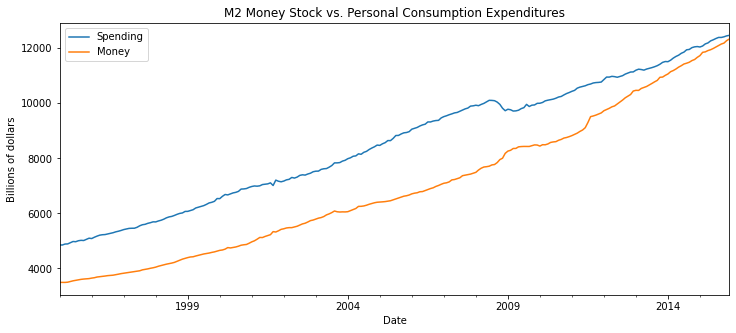

In [50]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel='Billions of dollars'
xlabel=''

ax = df['Spending'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Money'].plot(legend=True);

In [51]:
adf_test(df['Money'],title='Money')

Augmented Dickey-Fuller Test: Money
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [52]:
adf_test(df['Spending'], title='Spending')

Augmented Dickey-Fuller Test: Spending
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Neither variable is stationary, so we'll take a first order difference of the entire DataFrame and re-run the augmented Dickey-Fuller tests.

In [53]:
df_transformed = df.diff()
df_transformed = df_transformed.dropna()
adf_test(df_transformed['Money'], title='MoneyFirstDiff')
print()
adf_test(df_transformed['Spending'], title='SpendingFirstDiff')

Augmented Dickey-Fuller Test: MoneyFirstDiff
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

Augmented Dickey-Fuller Test: SpendingFirstDiff
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Since Money is not yet stationary, apply second order differencing to both series so they retain the same number of observations

In [54]:
 df_transformed = df_transformed.diff().dropna()
adf_test(df_transformed['Money'], title='MoneySecondDiff')
print()
adf_test(df_transformed['Spending'], title='SpendingSecondDiff')

Augmented Dickey-Fuller Test: MoneySecondDiff
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

Augmented Dickey-Fuller Test: SpendingSecondDiff
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [55]:
# stationary data
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [56]:
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [57]:
# VAR Model Order Selection
# Pyramid auto can't be applied here
for i in [1,2,3,4,5,6,7]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  14.178610495220896
BIC:  14.266409486135709

Order = 2
AIC:  13.955189367163705
BIC:  14.101961901274958

Order = 3
AIC:  13.849518291541038
BIC:  14.055621258341116

Order = 4
AIC:  13.827950574458281
BIC:  14.093744506408875

Order = 5
AIC:  13.78730034460964
BIC:  14.113149468980652

Order = 6
AIC:  13.799076756885809
BIC:  14.185349048538068

Order = 7
AIC:  13.797638727913972
BIC:  14.244705963046671



The VAR(5) model seems to return the lowest combined scores.

In [58]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 24, Apr, 2021
Time:                     04:37:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

In [59]:
# lagged order is 5
results.k_ar

5

In [60]:
# forecasted result
z = results.forecast(y=train.values[-results.k_ar:], steps=12)
z

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

In [61]:
df_forecast = pd.DataFrame(z, index=pd.date_range('1/1/2015', periods=12, freq='MS'), columns=['Money2d','Spending2d'])
df_forecast.head()

,Money2d,Spending2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365


In [62]:
# invert transformation due to 2nd order difference

# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [63]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [64]:
df_forecast.head()

,Money2d,Spending2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


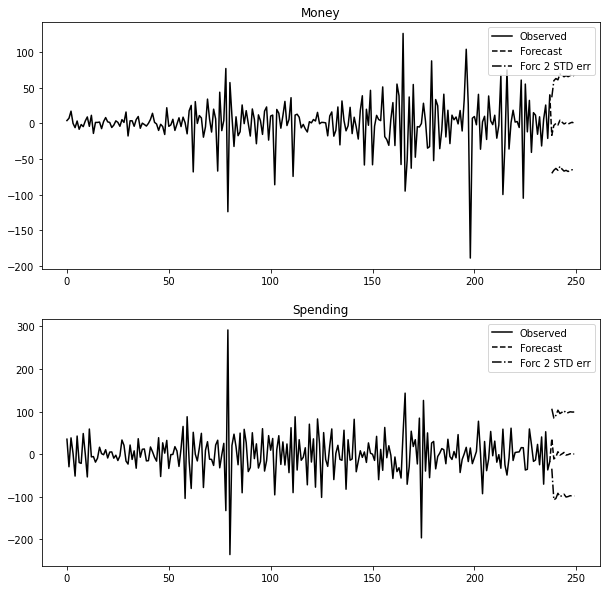

In [65]:
results.plot_forecast(12);

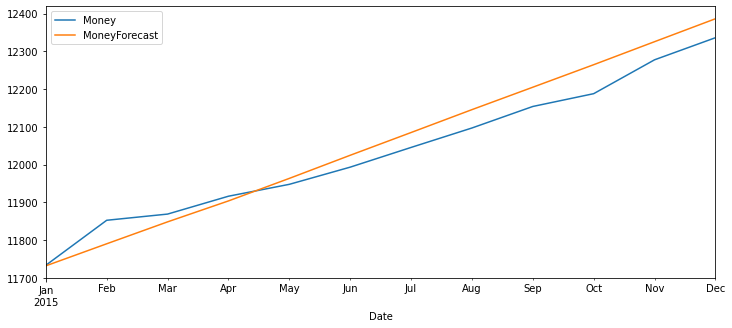

In [66]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

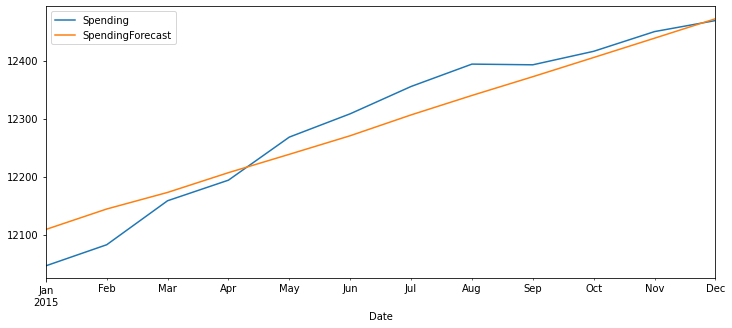

In [67]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

In [68]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Money VAR(5) RMSE: 43.710
Spending VAR(5) RMSE: 37.001


## VARMA (p,q)

In [69]:
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults

In [70]:
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [71]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [72]:
# can use pmdarima here
auto_arima(df_transformed['Money'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(1, 0, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [73]:
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]
model = VARMAX(train, order=(1,2), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2285.996
,+ intercept,AIC,4605.992
Date:,"Sat, 24 Apr 2021",BIC,4665.021
Time:,04:38:11,HQIC,4629.782
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.43, 0.01",Jarque-Bera (JB):,"560.85, 126.86"
Prob(Q):,"0.51, 0.94",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.63, 2.88",Skew:,"1.34, -0.33"


In [74]:
df_forecast = results.forecast(12)
df_forecast.head()

,Money,Spending
2015-01-01,-12.035301,38.130002
2015-02-01,-11.187154,-5.584689
2015-03-01,1.593082,0.025140
2015-04-01,-1.713970,-0.533339
2015-05-01,1.096811,0.343100


In [75]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [76]:
df_forecast.head()

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-12.035301,38.130002,66.564699,11658.064699,48.730002,12100.130002
2015-02-01,-11.187154,-5.584689,55.377545,11646.877545,43.145313,12094.545313
2015-03-01,1.593082,0.025140,56.970627,11648.470627,43.170453,12094.570453
2015-04-01,-1.713970,-0.533339,55.256657,11646.756657,42.637113,12094.037113
2015-05-01,1.096811,0.343100,56.353468,11647.853468,42.980214,12094.380214


In [77]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11658.064699,12100.130002
2015-02-01,11852.4,12082.4,11646.877545,12094.545313
2015-03-01,11868.8,12158.3,11648.470627,12094.570453
2015-04-01,11916.1,12193.8,11646.756657,12094.037113
2015-05-01,11947.6,12268.1,11647.853468,12094.380214
2015-06-01,11993.1,12308.3,11647.440751,12094.307646
2015-07-01,12045.3,12355.4,11647.959169,12094.503404
2015-08-01,12096.8,12394.0,11647.929332,12094.543422
2015-09-01,12153.8,12392.8,11648.227236,12094.676985


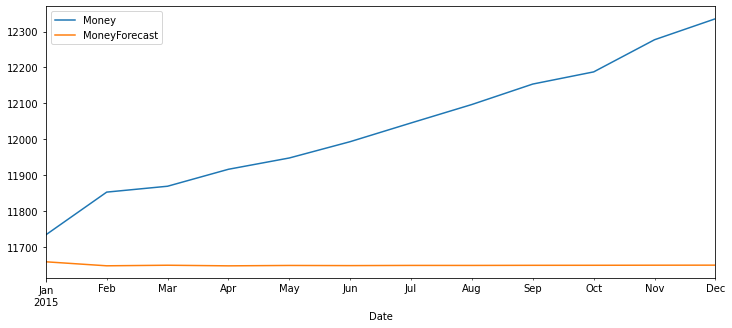

In [78]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

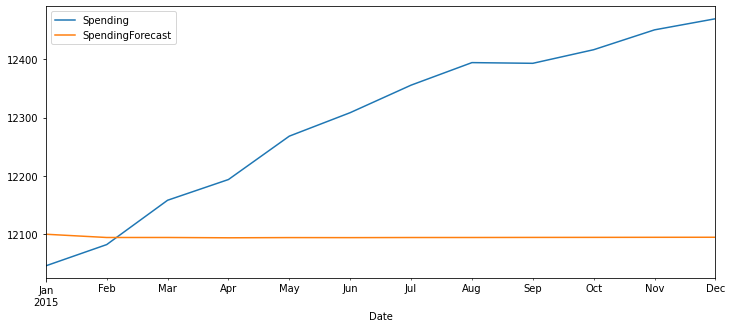

In [79]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

In [80]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Money VAR(5) RMSE: 423.467
Spending VAR(5) RMSE: 243.091


<strong>CONCLUSION:</strong> It looks like the VARMA(1,2) model did a relatively poor job compared to simpler alternatives. This tells us that there is little or no interdepence between Money Stock and Personal Consumption Expenditures, at least for the timespan we investigated. This is helpful! By fitting a model and getting poor results we know more about the data than we did before.